### P1. Superdense Coding

In [1]:
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
def SC_QC(bs): # bs='10' etc
    bs = [True if i=='1' else False for i in bs]
    qr = QuantumRegister(2, 'q0')
    cr = ClassicalRegister(2, 'c0')
    qc = QuantumCircuit(qr, cr)
    qc.h(1)
    qc.cx(1,0)
    qc.barrier()

    if bs[1]: qc.z(0)
    if bs[0]: qc.x(0)

    qc.barrier()
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()
    qc.measure(qr, cr)
    return qc

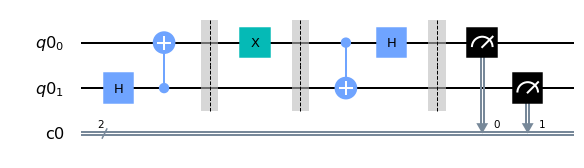

In [3]:
bs = '10'
qc = SC_QC(bs)
qc.draw(output = 'mpl') #, filename = 'SC')

In [4]:
import numpy
from numpy.random import randint

def array_to_str(arr):
    s = ''
    for i in arr: s += str(i)
    return s
    
def one_test(backend, bs = None, shots = 1024):
    if not bs: bs = array_to_str(randint(2, size=2))
    qc = SC_QC(bs)
    print(bs)
    qc.draw(output='mpl')
    job = execute(qc, backend, shots = shots)
    cnts = job.result().get_counts()
    return bs, cnts

In [5]:
from qiskit import Aer
_qasm_simulator = Aer.get_backend('qasm_simulator')

def SC_testing(backend = _qasm_simulator, N_exp = 20, shots = 1):
    correct = 0
    for i in range(N_exp): 
        idx, cnts =  one_test(backend, shots = shots)
        correct += cnts[idx]
    return correct, N_exp*shots, round(correct/(N_exp*shots),3)

In [6]:
SC_testing(N_exp = 1, shots = 100)

00


(100, 100, 1.0)

In [138]:
IBMQ.load_account()

/Users/pktsai/opt/anaconda3/envs/QChem/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [147]:
provider = IBMQ.get_provider(hub=  'ibm-q')
qc_provider = IBMQ.get_provider(project = 'q-chemistry')


backend = provider.get_backend('ibmq_athens')
qc_backend = qc_provider.get_backend('ibmq_rome')

In [164]:
job = SC_testing(backend = qc_backend, N_exp = 1, shots = 1024)

00


KeyboardInterrupt: 

### P2 Teleportation

In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute, IBMQ
from math import pi
from random import random

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(project = 'q-chemistry')
backend = provider.get_backend('ibmq_bogota')

/Users/pktsai/opt/anaconda3/envs/QChem/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


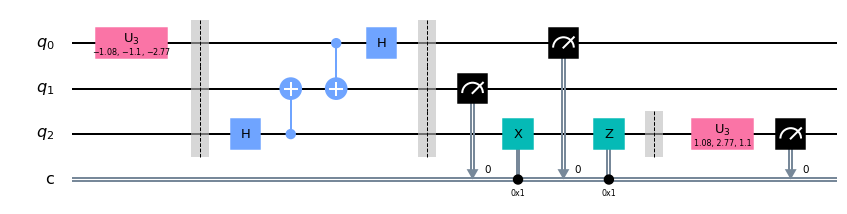

In [30]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qr, cr)

theta, phi, lamb = [2*pi*random()-pi for _ in range(3)]

qc.u3(theta, phi, lamb, 0)
qc.barrier()

qc.h(2)
qc.cx(2, 1)

qc.cx(0, 1)
qc.h(0)
qc.barrier()

qc.measure(1, 0)
qc.x(2).c_if(cr, 1)
qc.measure(0, 0)
qc.z(2).c_if(cr, 1)

qc.barrier(2)

qc.u3(-theta, -lamb, -phi, 2)

qc.measure(2, 0)

qc.draw('mpl', filename='teleportation')

In [6]:
sim_backend = Aer.get_backend('qasm_simulator')
sim_cnts = execute(qc, sim_backend).result().get_counts()
sim_cnts

{'0': 1024}

In [8]:
from qiskit.providers.aer.noise import NoiseModel
coupling_map = backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates

In [9]:
result_noise = execute(qc, sim_backend,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
noisy_cnts = result_noise.get_counts()
noisy_cnts

{'0': 930, '1': 94}

#### entanglement swapping

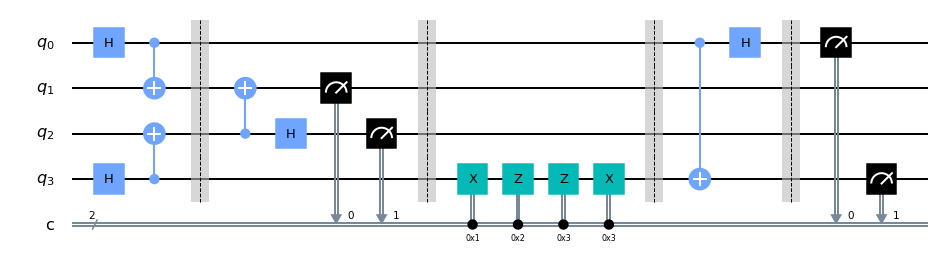

In [32]:
qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)

qc.h(0)
qc.cx(0, 1)
qc.h(3)
qc.cx(3,2)
qc.barrier()

qc.cx(2,1)
qc.h(2)
qc.measure([1,2], [0,1])
qc.barrier()

qc.x(3).c_if(cr, 1)
qc.z(3).c_if(cr, 2)
qc.z(3).c_if(cr, 3)
qc.x(3).c_if(cr, 3)
qc.barrier()

qc.cx(0,3)
qc.h(0)
qc.barrier()
qc.measure([0, 3], cr)

qc.draw('mpl') #, filename='entanglement swap')

In [33]:
cnts = execute(qc, sim_backend).result().get_counts()
cnts

{'00': 1024}

In [34]:
noisy_cnts = execute(qc, sim_backend,
                       noise_model=noise_model,
                       basis_gates=basis_gates).result().get_counts()
noisy_cnts

{'00': 823, '01': 113, '10': 67, '11': 21}

### P3. BB84

In [24]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute, IBMQ
from qiskit.visualization import plot_histogram

from math import pi
import numpy as np
from numpy.random import randint

In [27]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [35]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements


In [38]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits


In [58]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample


In [65]:
import numpy as np
def correct_ratio(a, b):
    assert len(a) == len(b)
    a = np.array(a)
    b = np.array(b)
    return len(list(filter(lambda i: i == True, a == b)))/len(a)

#### 3a

In [87]:
## 3a
n = 500

np.random.seed(seed=0)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
eve_key = remove_garbage(alice_bases, bob_bases, intercepted_message)

print(len(alice_key))
# print(list(alice_key))
# print(bob_key)
# print(eve_key)
print('Bob\'s success ratio:', correct_ratio(alice_key, bob_key))
print('Eve\'s success ratio:', correct_ratio(alice_key, eve_key))

261
[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0

#### 3b

In [91]:
## 3b
def eve_measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        message[q].ry(pi/4, 0)
        message[q].measure(0,0)

        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements


n = 100

np.random.seed(seed=0)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = eve_measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
eve_key = remove_garbage(alice_bases, bob_bases, intercepted_message)

print(len(alice_key))
# print(list(alice_key))
# print(bob_key)
# print(eve_key)
print('Bob\'s success ratio:', correct_ratio(alice_key, bob_key))
print('Eve\'s success ratio:', correct_ratio(alice_key, eve_key))

261
Bob's success ratio: 0.685823754789272
Eve's success ratio: 0.5134099616858238
